<h1 style='font-size: 25px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'>Tukey’s HSD for Pairwise Group Comparisons</h1>

---

Tukey’s Honest Significant Difference (HSD) test for pairwise group comparisons is a statistical method used to determine which specific groups differ from each other after finding a significant overall effect in an analysis of variance (ANOVA). In this project, the goal is to perform multiple comparisons between group means to identify exactly where differences lie, while controlling the overall Type I error rate. Tukey’s HSD adjusts for the fact that multiple pairwise tests increase the chance of false positives by using a stricter criterion for significance.

<h1 style='font-size: 18px;  font-weight: 600'>2.0: Import Required Libraries</h1>

In [1]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols as smf_ols 
from statsmodels.stats.anova import anova_lm 
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf
import statsmodels.api as sm  

from scipy.stats import skew, kurtosis, stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import math
import re

import warnings
warnings.simplefilter("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Libraries Loaded Successfully")

Libraries Loaded Successfully


<h1 style='font-size: 18px; font-weight: 600'>3.0: Import and Preprocessing Dataset</h1>

In [2]:
filepath = 'Datasets/Fertilizer and Light Exposure Experiment Dataset.csv'
df = pd.read_csv(filepath)
df.sample(10)

,Fertilizer,Light Exposure,Plant Height (cm),Leaf Area (cm²),Chlorophyll Content (SPAD units),Root Length (cm),Biomass (g),Flower Count (number),Seed Yield (g),Stomatal Conductance (mmol/m²/s)
72,Synthetic,Full Sun,78.45,241.59,45.30,32.43,17.06,23.47,7.45,319.00
43,Organic,Partial Shade,55.94,170.20,44.53,22.01,12.94,21.44,6.72,229.05
88,Synthetic,Full Sun,75.54,256.82,51.70,33.79,16.53,25.81,8.14,294.83
86,Control,Partial Shade,63.26,174.56,36.44,23.86,10.30,19.83,4.94,242.41
99,Organic,Full Sun,95.14,263.37,58.73,35.17,18.20,29.48,7.66,304.77
34,Control,Full Sun,58.66,197.21,38.25,21.66,12.56,18.38,8.14,296.38
59,Control,Full Sun,69.64,197.29,51.73,23.93,13.14,21.61,6.53,271.34
84,Organic,Partial Shade,63.95,181.28,42.08,24.24,11.66,17.81,5.71,226.86
68,Synthetic,Partial Shade,67.14,223.85,53.14,27.29,11.34,17.66,6.54,251.24
14,Synthetic,Full Shade,44.18,117.59,27.70,18.88,7.96,10.57,4.41,186.38


<h1 style='font-size: 18px; font-weight: 600'>4.0: Exploratory Data Analysis </h1>

Now, let’s move into Exploratory Data Analysis (EDA) — an important step where we take a closer look at our dataset to understand its structure, identify patterns, detect anomalies, and get a sense of the overall distribution of soil parameters. This will help us gain valuable insights and guide the direction of our statistical tests and interpretations.

<h2 style='font-size: 17px; font-weight: 600'>4.1: Dataset Informartion Overviews</h2>


In [17]:
df.shape

(120, 10)

In [18]:
for column in df.columns.tolist(): print(f"{'-'*15} {column}")

--------------- Fertilizer
--------------- Light Exposure
--------------- Plant Height (cm)
--------------- Leaf Area (cm²)
--------------- Chlorophyll Content (SPAD units)
--------------- Root Length (cm)
--------------- Biomass (g)
--------------- Flower Count (number)
--------------- Seed Yield (g)
--------------- Stomatal Conductance (mmol/m²/s)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fertilizer                        120 non-null    object 
 1   Light Exposure                    120 non-null    object 
 2   Plant Height (cm)                 120 non-null    float64
 3   Leaf Area (cm²)                   120 non-null    float64
 4   Chlorophyll Content (SPAD units)  120 non-null    float64
 5   Root Length (cm)                  120 non-null    float64
 6   Biomass (g)                       120 non-null    float64
 7   Flower Count (number)             120 non-null    float64
 8   Seed Yield (g)                    120 non-null    float64
 9   Stomatal Conductance (mmol/m²/s)  120 non-null    float64
dtypes: float64(8), object(2)
memory usage: 9.5+ KB


<h4 style='font-size: 15px; font-weight: 600'>4.1.2: Columns Summary</h4>

In [20]:
def column_summary(df):
    summary_data = []
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Fertilizer,object,0,120,3,"{'Control': 41, 'Synthetic': 40, 'Organic': 39}"
1,Light Exposure,object,0,120,3,"{'Full Shade': 44, 'Full Sun': 40, 'Partial Sh..."
2,Plant Height (cm),float64,0,120,120,"{58.56151388665052: 1, 46.696826238466286: 1, ..."
3,Leaf Area (cm²),float64,0,120,120,"{185.73856643236132: 1, 138.7980608962804: 1, ..."
4,Chlorophyll Content (SPAD units),float64,0,120,120,"{46.5196207922374: 1, 34.69363266870892: 1, 40..."
5,Root Length (cm),float64,0,120,120,"{24.31891050096943: 1, 17.6585349528435: 1, 26..."
6,Biomass (g),float64,0,120,120,"{11.994074041165357: 1, 8.667791843721698: 1, ..."
7,Flower Count (number),float64,0,120,120,"{19.53594616947752: 1, 15.366158832462084: 1, ..."
8,Seed Yield (g),float64,0,120,120,"{6.687959618540082: 1, 6.165373569255893: 1, 5..."
9,Stomatal Conductance (mmol/m²/s),float64,0,120,120,"{242.41380014645895: 1, 233.65862057163417: 1,..."


<h4 style='font-size: 15px; font-weight: 600'>4.1.3: Handling Duplicates Values</h4>

In [21]:
def handle_duplicates(df):
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        df.drop_duplicates(inplace=True)
        print(f"Found and removed {duplicate_count} duplicate rows successfully.")
    else:
        print("No duplicate rows found in the dataset.")


handle_duplicates(df)

No duplicate rows found in the dataset.


<h4 style='font-size: 15px;  font-weight: 600'>4.1.4: Checking Missing Values</h4>

Checking for missing values is a crucial step in data analysis to assess the completeness and reliability of the dataset. This involves identifying any columns with null or empty entries, which may affect the accuracy of statistical and machine learning models.

In [22]:
def Missig_values_info(df):   
    isna_df = df.isna().sum().reset_index(name='Missing Values Counts')
    isna_df['Proportions (%)'] = isna_df['Missing Values Counts']/len(df)*100
    return isna_df
    
isna_df = Missig_values_info(df)
isna_df

,index,Missing Values Counts,Proportions (%)
0,Fertilizer,0,0.000
1,Light Exposure,0,0.000
2,Plant Height (cm),0,0.000
3,Leaf Area (cm²),0,0.000
4,Chlorophyll Content (SPAD units),0,0.000
5,Root Length (cm),0,0.000
6,Biomass (g),0,0.000
7,Flower Count (number),0,0.000
8,Seed Yield (g),0,0.000
9,Stomatal Conductance (mmol/m²/s),0,0.000


<h4 style='font-size: 15px;  font-weight: 600'>4.1.5: Exploring Invalid Entries Dtypes</h4>

Exploring invalid entries in data types involves identifying values that do not match the expected format or category within each column. This includes detecting inconsistencies such as numerical values in categorical fields, incorrect data formats, or unexpected symbols and typos. Invalid entries can lead to errors in analysis and model performance, making it essential to standardize data types and correct anomalies.

In [23]:
def simplify_dtype(dtype):
    if dtype in (int, float, np.number): return 'Numeric'
    elif np.issubdtype(dtype, np.datetime64): return 'Datetime'
    elif dtype == str: return 'String'
    elif dtype == type(None): return 'Missing'
    else: return 'Other'

def analyze_column_dtypes(df):
    all_dtypes = {'Numeric', 'Datetime', 'String', 'Missing', 'Other'}
    results = pd.DataFrame(index=df.columns, columns=list(all_dtypes), dtype=object).fillna('-')
    
    for column in df.columns:
        dtypes = df[column].apply(lambda x: simplify_dtype(type(x))).value_counts()
        percentages = (dtypes / len(df)) * 100
        for dtype, percent in percentages.items():
            if percent > 0:
                results.at[column, dtype] = f'{percent:.2f}%'  # Add % sign and format to 2 decimal places
            else:
                results.at[column, dtype] = '-'  # Add dash for 0%
    return results

results = analyze_column_dtypes(df)
display(results)

,Numeric,Other,Missing,Datetime,String
Fertilizer,-,-,-,-,100.00%
Light Exposure,-,-,-,-,100.00%
Plant Height (cm),100.00%,-,-,-,-
Leaf Area (cm²),100.00%,-,-,-,-
Chlorophyll Content (SPAD units),100.00%,-,-,-,-
Root Length (cm),100.00%,-,-,-,-
Biomass (g),100.00%,-,-,-,-
Flower Count (number),100.00%,-,-,-,-
Seed Yield (g),100.00%,-,-,-,-
Stomatal Conductance (mmol/m²/s),100.00%,-,-,-,-


<h2 style='font-size: 17px;  font-weight: 600'>4.2: Detection and Handling Outliers</h2>

An outlier is a data point that significantly deviates from the rest of the dataset, appearing as an unusually high or low value. Outliers may arise from errors, data entry mistakes, or natural variations, and can distort statistical analysis and machine learning models. To maintain data integrity, outliers should be detected using methods like Z-scores, IQR, or visual tools (e.g., box plots), and then handled appropriately.

<h4 style='font-size: 15px;  font-weight: 600'>4.2.1: Visualize Outliers Using Boxplots</h4>

To gain a more visual and intuitive understanding of how outliers are distributed, we can use **boxplots**. Boxplots not only show the spread and center of the data but also clearly highlight outliers as individual points outside the whiskers, making it easy to see which variables and groups have more extreme values.

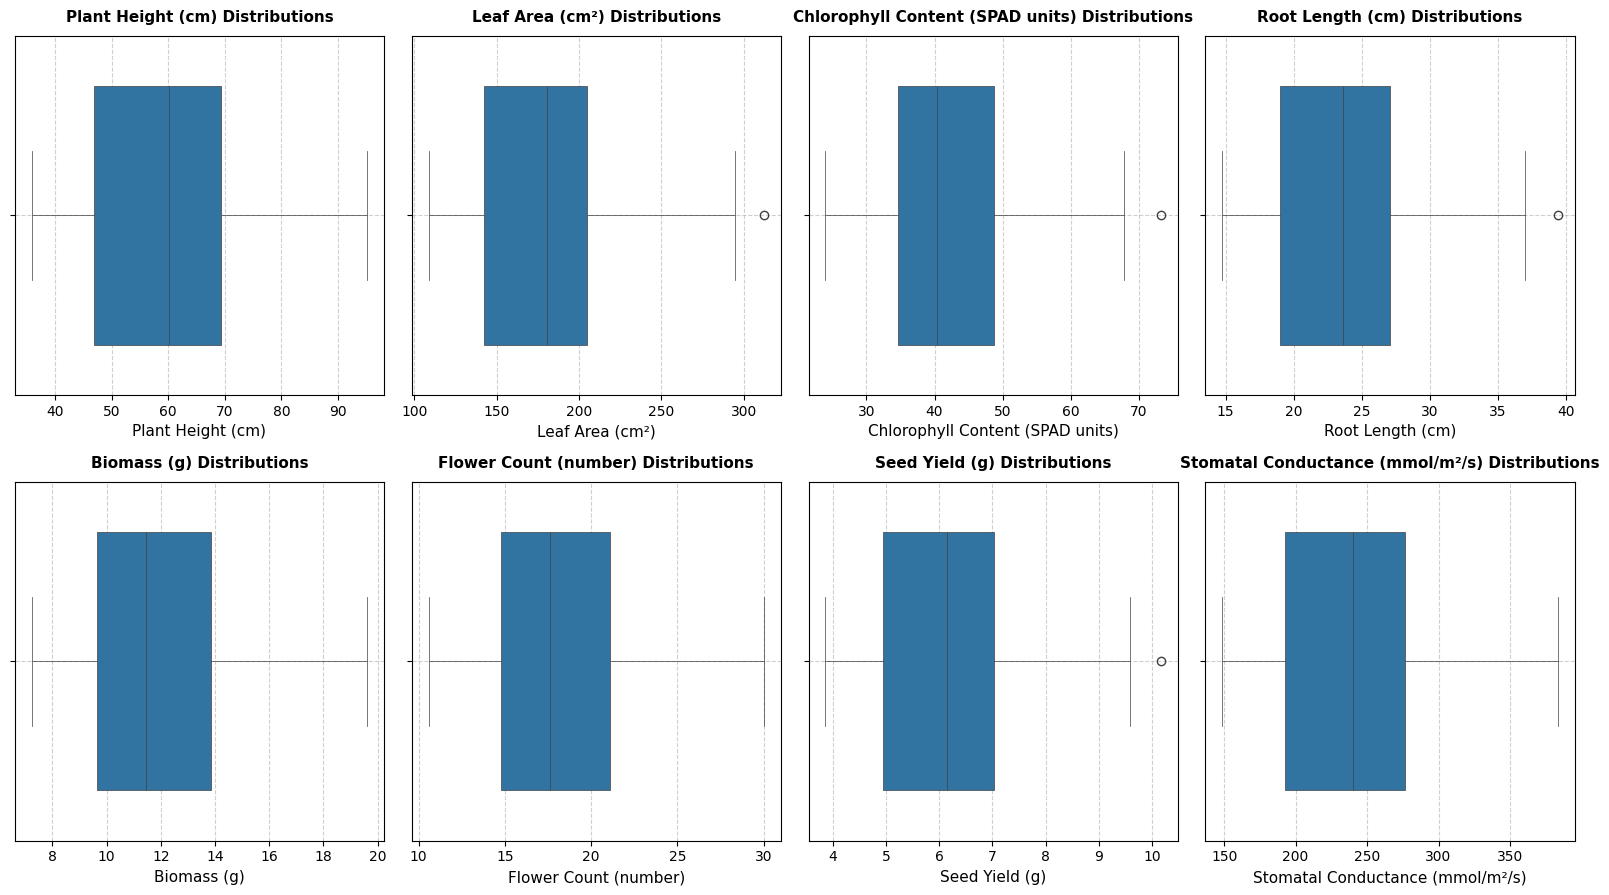

In [24]:
def plot_boxplot(df, Metrics, group_col=None):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 4)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Metrics):
        sns.boxplot(data=df, x=df[column], fill=True, hue=group_col, ax=axes[idx], gap=0.1, linewidth=0.5)   
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        if group_col: axes[idx].set_title(f"{column} Distributions by {group_col}", fontsize=11, pad=10, fontweight='bold')
        
        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
        if group_col: axes[idx].legend(frameon=False)
        
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
Metrics = df.select_dtypes(include=[np.number]).columns
plot_boxplot(df, Metrics)

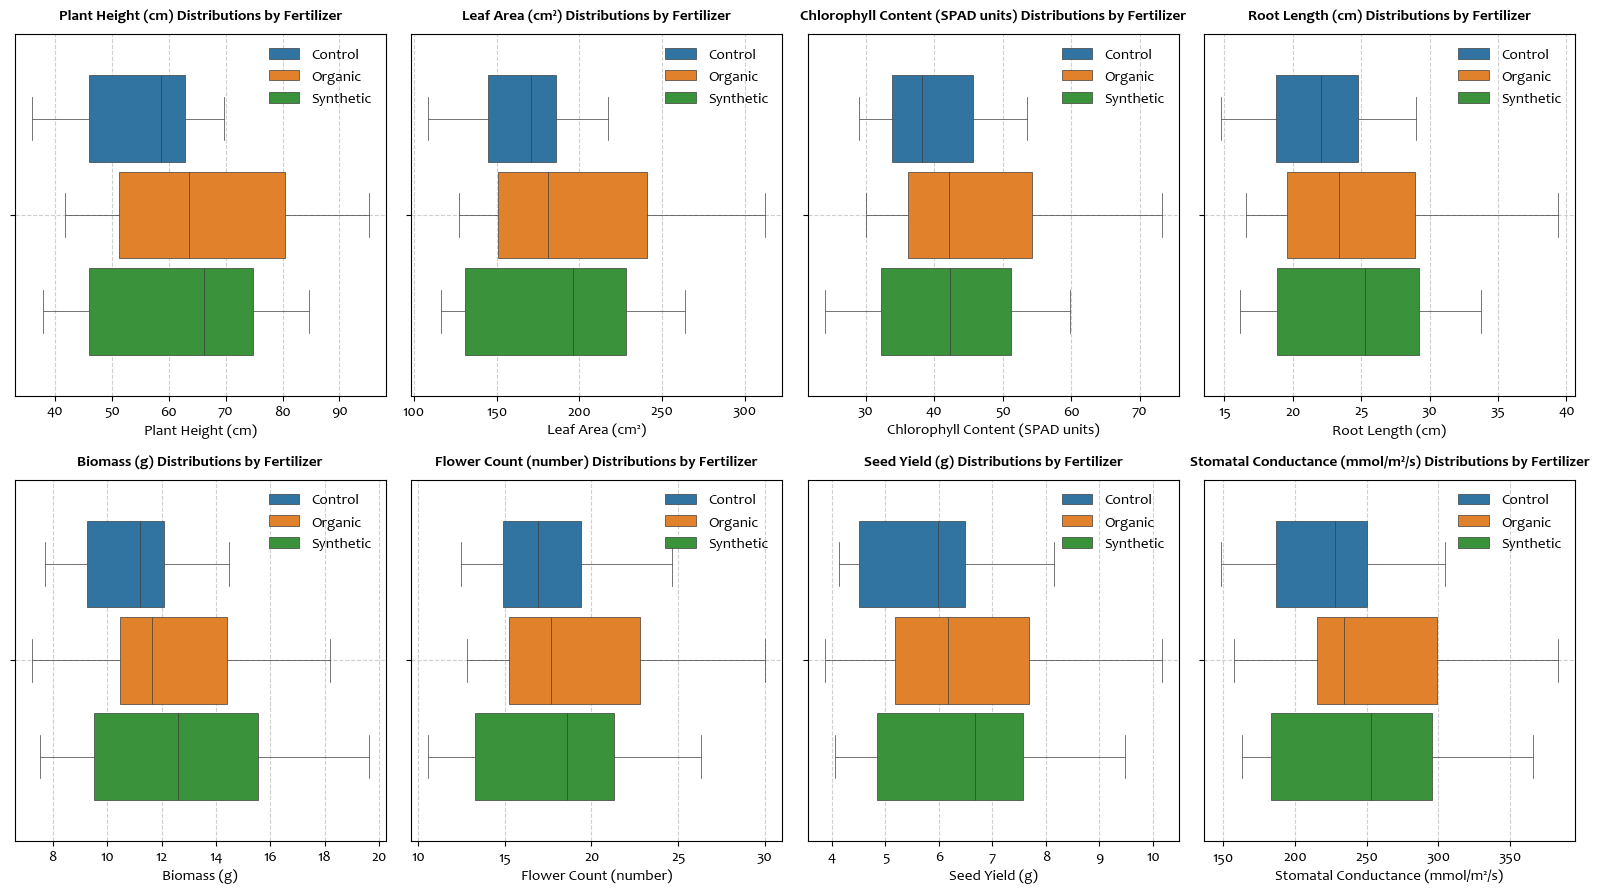

In [26]:
Metrics = df.select_dtypes(include=[np.number]).columns
plot_boxplot(df, Metrics, group_col='Fertilizer')

<h4 style='font-size: 15px;  font-weight: 600'>4.2.2: Explore Outlier Anomalies Using the IQR Method</h4>

Now, let’s explore outliers in our data using the Interquartile Range (IQR) method. This approach helps us identify extreme values by checking which data points fall far below or above the typical range for each variable. By detecting these anomalies, both overall and within groups, we can better understand the data’s variability and decide if any values need closer attention or cleaning.

In [27]:
def detect_outliers_overall(df):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    outlier_counts = {}
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
        outlier_counts[col] = count
    
    total_obs = df.shape[0]
    result = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
    result.loc['Total Observations'] = [total_obs]
    
    return result.astype(int)

overall_outliers = detect_outliers_overall(df)
display(overall_outliers)

,Outlier Count
Plant Height (cm),0
Leaf Area (cm²),1
Chlorophyll Content (SPAD units),1
Root Length (cm),1
Biomass (g),0
Flower Count (number),0
Seed Yield (g),1
Stomatal Conductance (mmol/m²/s),0
Total Observations,120


The current implementation only returns the counts and proportions of outliers in the dataset, but it doesn’t show which specific groups those outliers belong to. To get a clearer picture, we can create plots that compare outlier distributions across groups, helping us identify which groups are most affected.

In [28]:
def detect_outliers_by_group(df, group_col):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    outlier_summary = pd.DataFrame(index=numeric_cols)

    grouped = df.groupby(group_col)
    for group_name, group_data in grouped:
        outlier_counts = []
        for col in numeric_cols:
            Q1 = group_data[col].quantile(0.25)
            Q3 = group_data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            count = group_data[(group_data[col] < lower) | (group_data[col] > upper)].shape[0]
            outlier_counts.append(count)
        outlier_summary[group_name] = outlier_counts

    total_row = df.groupby(group_col).size()
    outlier_summary.loc["Total Observations"] = total_row

    return outlier_summary.fillna(0).astype(int)

outliers_table = detect_outliers_by_group(df, group_col='Fertilizer')
display(outliers_table)


,Control,Organic,Synthetic
Plant Height (cm),0,0,0
Leaf Area (cm²),0,0,0
Chlorophyll Content (SPAD units),0,0,0
Root Length (cm),0,0,0
Biomass (g),0,0,0
Flower Count (number),0,0,0
Seed Yield (g),0,0,0
Stomatal Conductance (mmol/m²/s),0,0,0
Total Observations,41,39,40


<h2 style='font-size: 17px; font-weight: 600'>4.3: Statistic Description of The Datasets</h2>

Let's take a moment to quickly explore some essential statistics of our dataset. By using the `describe()` function in pandas, we can generate a summary of key metrics for each numerical column in the dataset. This gives us a bird's-eye view of the data, helping us understand the general distribution and characteristics of the values.

In [29]:
summary_stats = df.describe().T.reset_index()
summary_stats

,index,count,mean,std,min,25%,50%,75%,max
0,Plant Height (cm),120.000,60.575,14.930,35.887,46.817,60.183,69.332,95.143
1,Leaf Area (cm²),120.000,181.904,45.935,108.647,142.324,180.705,204.998,312.304
2,Chlorophyll Content (SPAD units),120.000,42.025,9.864,23.988,34.582,40.366,48.660,73.212
3,Root Length (cm),120.000,23.859,5.436,14.751,19.010,23.640,27.071,39.399
4,Biomass (g),120.000,11.969,2.886,7.230,9.630,11.455,13.869,19.614
5,Flower Count (number),120.000,18.184,4.428,10.574,14.798,17.644,21.082,30.027
6,Seed Yield (g),120.000,6.165,1.488,3.862,4.941,6.140,7.030,10.164
7,Stomatal Conductance (mmol/m²/s),120.000,241.683,55.736,148.685,192.689,240.246,276.737,383.448



<h4 style='font-size: 15px;  font-weight: 600'>4.3.1: Distribution of Continuous variables</h4>


Let’s explore the distribution of **continuous variables** in our dataset by examining key statistics. The ***Mean*** gives us the average value, while the ***Median*** provides the middle value, offering a more robust measure against outliers. The ***Mode*** identifies the most frequent value. ***Standard Deviation*** and ***Variance*** show how much the data deviates from the mean, with larger values indicating greater spread. The ***Range*** reveals the difference between the maximum and minimum values, while ***Skewness*** measures the symmetry of the distribution. Lastly, ***Kurtosis*** tells us about the presence of outliers by analyzing the **"tailedness"** of the distribution. Together, these metrics give us a comprehensive view of how the data is distributed and guide us in identifying any potential issues like skewness or outliers.

In [30]:
def distribution_statistics(df):
    results = []
    for col in df.select_dtypes(include=[np.number]).columns:
        mean = df[col].mean()
        median = df[col].median()
        mode = df[col].mode().iloc[0] if not df[col].mode().empty else np.nan
        std_dev = df[col].std()
        variance = df[col].var()
        value_range = df[col].max() - df[col].min()
        skewness_val = skew(df[col], nan_policy='omit')  # Skewness
        kurtosis_val = kurtosis(df[col], nan_policy='omit')  # Kurtosis


        results.append({
            'Parameter': col,
            'Mean': mean,
            'Median': median,
            'Mode': mode,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Range': value_range,
            'Skewness': skewness_val,
            'Kurtosis': kurtosis_val
        })

    
    result_df = pd.DataFrame(results)
    return result_df

pd.set_option('display.max_columns', 10) 
Continuous_variables_distribution = distribution_statistics(df)
display(Continuous_variables_distribution)

,Parameter,Mean,Median,Mode,Standard Deviation,Variance,Range,Skewness,Kurtosis
0,Plant Height (cm),60.575,60.183,35.887,14.930,222.898,59.256,0.375,-0.733
1,Leaf Area (cm²),181.904,180.705,108.647,45.935,2109.987,203.657,0.560,-0.317
2,Chlorophyll Content (SPAD units),42.025,40.366,23.988,9.864,97.292,49.224,0.589,-0.169
3,Root Length (cm),23.859,23.640,14.751,5.436,29.549,24.648,0.617,-0.217
4,Biomass (g),11.969,11.455,7.230,2.886,8.331,12.384,0.595,-0.482
5,Flower Count (number),18.184,17.644,10.574,4.428,19.603,19.453,0.619,-0.262
6,Seed Yield (g),6.165,6.140,3.862,1.488,2.213,6.303,0.504,-0.505
7,Stomatal Conductance (mmol/m²/s),241.683,240.246,148.685,55.736,3106.477,234.763,0.413,-0.580


<h4 style='font-size: 15px; font-weight: 600'>4.3.2: Group-wise Distribution of Continuous variables</h4>

To explore the group-wise distribution of continuous variables, we group the data using a categorical column (the "group" column) and then compute descriptive statistics for each group. This helps us understand how the continuous variables differ across categories and reveals patterns or variations within the data.


In [31]:
def group_distribution_stats(df, group_column):
    results = []
    grouped = df.groupby(group_column)
    for col in df.select_dtypes(include=[np.number]).columns:
        if col != group_column:
            for group_name, group_data in grouped:
                mean = group_data[col].mean()
                median = group_data[col].median()
                mode = group_data[col].mode().iloc[0] if not group_data[col].mode().empty else np.nan
                std_dev = group_data[col].std()
                variance = group_data[col].var()
                cv = group_data[col].std() / group_data[col].mean() * 100  # Coefficient of Variation
                value_range = group_data[col].max() - group_data[col].min()
                
        
                skewness_val = skew(group_data[col], nan_policy='omit')  # Skewness
                kurtosis_val = kurtosis(group_data[col], nan_policy='omit')  # Kurtosis
                
                
                n = len(group_data[col])  # Sample size
                sem = std_dev / np.sqrt(n) if n > 1 else np.nan  # Standard error of the mean

                # Append the results to the list
                results.append({
                    group_column: group_name,
                    'Variables': col,
                    'Mean': mean,
                    'SEM': sem,
                    'Median': median,
                    'Mode': mode,
                    'Standard Deviation': std_dev,
                    'Variance': variance,
                    'Coefficient of Variation': cv,
                    'Range': value_range,
                    'Skewness': skewness_val,
                    'Kurtosis': kurtosis_val,
                })

    result_df = pd.DataFrame(results)
    return result_df

group_column = 'Fertilizer'
pd.set_option('display.max_columns', 15) 
results = group_distribution_stats(df, group_column)
display(results)

,Fertilizer,Variables,Mean,SEM,Median,Mode,Standard Deviation,Variance,Coefficient of Variation,Range,Skewness,Kurtosis
0,Control,Plant Height (cm),54.553,1.576,58.562,35.887,10.094,101.889,18.503,33.754,-0.352,-1.212
1,Organic,Plant Height (cm),65.613,2.695,63.555,41.824,16.828,283.185,25.647,53.319,0.324,-1.238
2,Synthetic,Plant Height (cm),61.836,2.422,66.135,37.818,15.315,234.561,24.768,46.862,-0.113,-1.467
3,Control,Leaf Area (cm²),167.758,4.324,170.863,108.647,27.690,766.716,16.506,108.936,-0.335,-0.716
4,Organic,Leaf Area (cm²),194.255,8.369,181.278,127.177,52.267,2731.823,26.906,185.127,0.690,-0.701
5,Synthetic,Leaf Area (cm²),184.361,8.095,196.223,116.324,51.195,2620.914,27.769,147.573,-0.046,-1.516
6,Control,Chlorophyll Content (SPAD units),39.756,1.119,38.280,29.065,7.165,51.341,18.023,24.422,0.353,-1.002
7,Organic,Chlorophyll Content (SPAD units),44.851,1.768,42.085,30.075,11.039,121.858,24.613,43.137,0.793,-0.353
8,Synthetic,Chlorophyll Content (SPAD units),41.596,1.672,42.264,23.988,10.578,111.888,25.430,35.850,0.039,-1.310
9,Control,Root Length (cm),21.971,0.584,22.087,14.751,3.740,13.984,17.020,14.223,-0.115,-1.057


<h4 style='font-size: 15px; font-weight: 600'>4.3.3: Group-wise Comparatives Analysis of Continuous variables</h4>

Now, let’s turn our attention to comparing the means of variables across different specified groups. By grouping the data based on a categorical feature, we can calculate the mean of each continuous variable within each group. This allows us to identify differences or similarities in average values between groups, offering insights into how the variable behaves under different conditions or categories.


In [32]:
def summary_stats(df, group=''):
    Metrics = df.select_dtypes(include=np.number).columns.tolist()
    df_without_location = df.drop(columns=[group])
    grand_mean = df_without_location[Metrics].mean()
    sem = df_without_location[Metrics].sem()
    cv = df_without_location[Metrics].std() / df_without_location[Metrics].mean() * 100
    grouped = df.groupby(group)[Metrics].agg(['mean', 'sem']).reset_index()
    
    summary_df = pd.DataFrame()
    for col in Metrics:
        summary_df[col] = grouped.apply(
            lambda x: f"{x[(col, 'mean')]:.2f} ± {x[(col, 'sem')]:.2f}", axis=1
        )
    
    summary_df.insert(0, group, grouped[group])
    grand_mean_row = ['Grand Mean'] + grand_mean.tolist()
    sem_row = ['SEM'] + sem.tolist()
    cv_row = ['%CV'] + cv.tolist()
    
    summary_df.loc[len(summary_df)] = grand_mean_row
    summary_df.loc[len(summary_df)] = sem_row
    summary_df.loc[len(summary_df)] = cv_row
    
    return summary_df


results = summary_stats(df, group='Fertilizer')
results.T

,0,1,2,3,4,5
Fertilizer,Control,Organic,Synthetic,Grand Mean,SEM,%CV
Plant Height (cm),54.55 ± 1.58,65.61 ± 2.69,61.84 ± 2.42,60.575,1.363,24.647
Leaf Area (cm²),167.76 ± 4.32,194.26 ± 8.37,184.36 ± 8.09,181.904,4.193,25.252
Chlorophyll Content (SPAD units),39.76 ± 1.12,44.85 ± 1.77,41.60 ± 1.67,42.025,0.900,23.471
Root Length (cm),21.97 ± 0.58,25.15 ± 1.03,24.53 ± 0.86,23.859,0.496,22.784
Biomass (g),10.91 ± 0.26,12.56 ± 0.47,12.48 ± 0.56,11.969,0.263,24.116
Flower Count (number),17.13 ± 0.48,19.36 ± 0.82,18.12 ± 0.75,18.184,0.404,24.349
Seed Yield (g),5.68 ± 0.17,6.41 ± 0.26,6.43 ± 0.25,6.165,0.136,24.132
Stomatal Conductance (mmol/m²/s),221.38 ± 6.67,256.74 ± 9.06,247.81 ± 9.74,241.683,5.088,23.062


<h1 style='font-size: 18px; font-weight: 600'>5.0. Analysis of Varience (ANOVA)</h1>
<h4 style='font-size: 15px; font-weight: 600'>5.1: Analysis of Varience (One Way ANOVA)</h4>


A one-way ANOVA (Analysis of Variance) is a statistical test used to determine if there are significant differences between the means of three or more independent groups based on a single factor (or independent variable). It assesses whether the factor has an effect on the dependent variable. If the p-value from the test is less than a specified significance level (usually 0.05), it suggests that at least one group mean is significantly different from the others. The test assumes that the data is normally distributed, the variances are equal across groups (homogeneity of variance), and the observations are independent.

In [33]:
def rename(text): return re.sub(r'[^a-zA-Z]', "", text)
    
def One_way_anova(data, Metrics, group_cols):
    results = []
    original_group_cols = group_cols[:]  # Save original names for reporting
    group_cols = [rename(col) for col in group_cols]
    data = data.rename(columns={col: rename(col) for col in data.columns})
    
    for original_group, group in zip(original_group_cols, group_cols):
        for col in Metrics:
            column_name = rename(col)  
            formula = f"{column_name} ~ C({group})" 
            model = smf.ols(formula, data=data).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            
            for source, row in anova_table.iterrows():
                p_value = row["PR(>F)"]
                interpretation = "Significant" if p_value < 0.05 else "No significant"
                if source == "Residual":
                    interpretation = "-"
                
                results.append({
                    "Variable": col,
                    #"Factor": original_group,  # Use original name here
                    "Source": source,
                    "Sum Sq": row["sum_sq"],
                    "df": row["df"],
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Interpretation": interpretation
                })

    return pd.DataFrame(results)

group_cols = ["Fertilizer", "Light Exposure"]
Metrics = ['Plant Height (cm)', 'Leaf Area (cm²)','Chlorophyll Content (SPAD units)', 'Root Length (cm)', 'Biomass (g)', 
           'Flower Count (number)', 'Seed Yield (g)']
Anova_results = One_way_anova(df, Metrics, group_cols)
Anova_results

,Variable,Source,Sum Sq,df,F-Value,p-Value,Interpretation
0,Plant Height (cm),C(Fertilizer),2540.401,2.000,6.196,0.003,Significant
1,Plant Height (cm),Residual,23984.470,117.000,NaN,NaN,-
2,Leaf Area (cm²),C(Fertilizer),14394.905,2.000,3.558,0.032,Significant
3,Leaf Area (cm²),Residual,236693.541,117.000,NaN,NaN,-
4,Chlorophyll Content (SPAD units),C(Fertilizer),529.815,2.000,2.805,0.065,No significant
5,Chlorophyll Content (SPAD units),Residual,11047.886,117.000,NaN,NaN,-
6,Root Length (cm),C(Fertilizer),229.565,2.000,4.086,0.019,Significant
7,Root Length (cm),Residual,3286.707,117.000,NaN,NaN,-
8,Biomass (g),C(Fertilizer),70.053,2.000,4.448,0.014,Significant
9,Biomass (g),Residual,921.365,117.000,NaN,NaN,-


<h4 style='font-size: 15px; font-weight: 600'>5.2: Tukey's Honest Significant Difference (THSD)</h4>

Now, let's perform Tukey’s Honest Significant Difference (THSD) test to determine which groups are statistically similar or different. While ANOVA tells us if there is a significant difference among groups, it does not specify which groups differ. Tukey’s HSD helps by comparing all possible group pairs and assigning statistical significance to their differences. This step is crucial in identifying which groups share similarities and which ones are distinct, allowing for a more detailed interpretation of the results.

In [5]:
def Turkey_results(df, Metrics, group=''):
    results_data = []
    for metric in Metrics:
        turkey_results = pairwise_tukeyhsd(endog=df[metric], groups=df[group], alpha=0.05)
        results_table = turkey_results.summary()
        
        for i in range(1, len(results_table)):
            row = results_table.data[i]
            results_data.append({
                'Metric': metric,
                'Group1': row[0],
                'Group2': row[1],
                'Mean Difference': row[2],
                'P-Value': row[3],
                'Lower CI': row[4],
                'Upper CI': row[5],
                'Reject Null': row[6]
            })
        
        result_df = pd.DataFrame(results_data)
    return result_df

Metrics = df.select_dtypes(include=[np.number]).columns
Turkeyresults = Turkey_results(df, Metrics, group='Fertilizer')
pd.set_option("display.float_format", "{:.3f}".format)
Turkeyresults

,Metric,Group1,Group2,Mean Difference,P-Value,Lower CI,Upper CI,Reject Null
0,Plant Height (cm),Control,Organic,11.060,0.002,3.458,18.663,True
1,Plant Height (cm),Control,Synthetic,7.283,0.061,-0.271,14.837,False
2,Plant Height (cm),Organic,Synthetic,-3.777,0.472,-11.426,3.872,False
3,Leaf Area (cm²),Control,Organic,26.497,0.026,2.614,50.380,True
4,Leaf Area (cm²),Control,Synthetic,16.602,0.225,-7.127,40.331,False
5,Leaf Area (cm²),Organic,Synthetic,-9.895,0.593,-33.923,14.133,False
6,Chlorophyll Content (SPAD units),Control,Organic,5.094,0.054,-0.065,10.254,False
7,Chlorophyll Content (SPAD units),Control,Synthetic,1.839,0.672,-3.287,6.966,False
8,Chlorophyll Content (SPAD units),Organic,Synthetic,-3.255,0.300,-8.446,1.936,False
9,Root Length (cm),Control,Organic,3.183,0.022,0.369,5.998,True


<h4 style='font-size: 15px; font-weight: 600'>5.3: Compact Letter Display (CLD)</h4>

Now, let's compute the **Compact Letter Display (CLD)** across group pairs to summarize the statistical differences between them in a clear and concise table. CLD helps visually represent which groups differ significantly in their means by assigning letters—groups sharing the same letter are not significantly different. This summary makes it easier to interpret multiple pairwise comparisons simultaneously, providing an intuitive overview of group similarities and differences across the dataset.


In [7]:
def Compact_letters_display(df, Factor='', exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    def calculate_stats_for_column(col_name):
        model = smf_ols(f'{col_name}~C({Factor})', data=df).fit()
        anova_results = anova_lm(model)
        p_value = anova_results.loc[f'C({Factor})', 'PR(>F)']
        tukey = pairwise_tukeyhsd(df[col_name], df[Factor])
        Turkey_results = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        group_labels = letters(Turkey_results)
        stats = df.groupby(Factor)[col_name].agg(['mean', 'sem']).round(2)
        stats['letter'] = stats.index.map(group_labels)
        stats['formatted'] = stats.apply(
            lambda x: f"{x['mean']:.2f} ± {x['sem']:.2f} {x['letter']}", axis=1)
        
        return stats['formatted'], p_value
    results = {}
    p_values = {}
    for col in numeric_cols:
        results[col], p_values[col] = calculate_stats_for_column(col)
    
    results_df = pd.DataFrame(results)
    results_df.index.name = Factor
    p_values_formatted = {col: f"{p:.4f}" + ('***' if p <= 0.001 else '**' if p <= 0.01 else '*' if p <= 0.05 else 'ns') 
                         for col, p in p_values.items()}
    p_value_df = pd.DataFrame([p_values_formatted], index=['p-value'])
    final_results = pd.concat([results_df, p_value_df])
    return final_results

def letters(df, alpha=0.05):
    df["p-adj"] = df["p-adj"].astype(float)
    group1 = set(df.group1.tolist())
    group2 = set(df.group2.tolist())
    groupSet = group1 | group2
    groups = list(groupSet)
    letters = list(string.ascii_lowercase)[:len(groups)]
    cldgroups = letters
    cld = pd.DataFrame(list(zip(groups, letters, cldgroups)))
    cld[3] = ""
    
    for row in df.itertuples():
        if df["p-adj"][row[0]] > alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 2] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 2] += cld.loc[groups.index(df["group1"][row[0]]), 1]
        if df["p-adj"][row[0]] < alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 3] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 3] += cld.loc[groups.index(df["group1"][row[0]]), 1]
    
    cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
    cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
    cld.rename(columns={0: "groups"}, inplace=True)
    cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())
    cld["labels"] = ""
    letters = list(string.ascii_lowercase)
    unique = []
    
    for item in cld[2]:
        for fitem in cld["labels"].unique():
            for c in range(len(fitem)):
                if not set(unique).issuperset(set(fitem[c])):
                    unique.append(fitem[c])
        g = len(unique)
        for kitem in cld[1]:
            if kitem in item:
                if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                    cld.loc[cld[1] == kitem, "labels"] += letters[g]
                if kitem in " ".join(cld.loc[cld["labels"] == letters[g], 3]):
                    g = len(unique) + 1
                if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0]).intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                    if letters[g] not in list(cld.loc[cld[1] == kitem, "labels"].iloc[0]):
                        cld.loc[cld[1] == kitem, "labels"] += letters[g]
                    if letters[g] not in list(cld.loc[cld[2] == item, "labels"].iloc[0]):
                        cld.loc[cld[2] == item, "labels"] += letters[g]
    
    cld = cld.sort_values("labels")
    cld.drop(columns=[1, 2, 3], inplace=True)
    cld = dict(zip(cld["groups"], cld["labels"]))
    return cld

def compact_letter_table(df, group, savepath=None):
    data = df.copy()
    group_col = rename(group)
    data.columns = data.columns.to_series().apply(rename)
    results_df = Compact_letters_display(data, Factor=group_col)
    results_df_columns = df.select_dtypes(include=[np.number]).columns
    results_df.columns = results_df_columns
    if savepath: results_df.to_csv(savepath, index=False)
    return results_df

<h4 style='font-size: 15px; font-weight: 600'>5.4: Compact Letter Display (CLD) Tables</h4>


In [16]:
results = compact_letter_table(df, group="Fertilizer", savepath=None)
display(results.T)

,Control,Organic,Synthetic,p-value
Plant Height (cm),54.55 ± 1.58 a,65.61 ± 2.69 b,61.84 ± 2.42 ab,0.0028**
Leaf Area (cm²),167.76 ± 4.32 a,194.26 ± 8.37 b,184.36 ± 8.09 ab,0.0316*
Chlorophyll Content (SPAD units),39.76 ± 1.12 a,44.85 ± 1.77 a,41.60 ± 1.67 a,0.0646ns
Root Length (cm),21.97 ± 0.58 a,25.15 ± 1.03 b,24.53 ± 0.86 ab,0.0193*
Biomass (g),10.91 ± 0.26 a,12.56 ± 0.47 b,12.48 ± 0.56 b,0.0137*
Flower Count (number),17.13 ± 0.48 a,19.36 ± 0.82 a,18.12 ± 0.75 a,0.0766ns
Seed Yield (g),5.68 ± 0.17 a,6.41 ± 0.26 a,6.43 ± 0.25 a,0.0339*
Stomatal Conductance (mmol/m²/s),221.38 ± 6.67 a,256.74 ± 9.06 b,247.81 ± 9.74 ab,0.0113*


In [15]:
results = compact_letter_table(df, group="Light Exposure", savepath=None)
display(results.T)

,Full Shade,Full Sun,Partial Shade,p-value
Plant Height (cm),45.39 ± 0.78 c,74.39 ± 1.81 b,63.78 ± 1.30 a,0.0000***
Leaf Area (cm²),136.79 ± 2.32 c,227.23 ± 5.95 b,186.68 ± 3.22 a,0.0000***
Chlorophyll Content (SPAD units),33.02 ± 0.62 c,52.17 ± 1.18 b,41.76 ± 0.88 a,0.0000***
Root Length (cm),18.52 ± 0.26 c,28.84 ± 0.77 b,24.84 ± 0.37 a,0.0000***
Biomass (g),9.29 ± 0.16 c,14.77 ± 0.38 b,12.12 ± 0.27 a,0.0000***
Flower Count (number),13.86 ± 0.21 c,22.76 ± 0.55 b,18.39 ± 0.30 a,0.0000***
Seed Yield (g),4.68 ± 0.07 c,7.66 ± 0.18 b,6.32 ± 0.11 a,0.0000***
Stomatal Conductance (mmol/m²/s),187.67 ± 3.29 c,294.33 ± 7.03 b,249.19 ± 4.95 a,0.0000***


<h4 style='font-size: 15px; font-weight: 600'>5.5: Compact Letter Display (CLD) Visualization</h4>


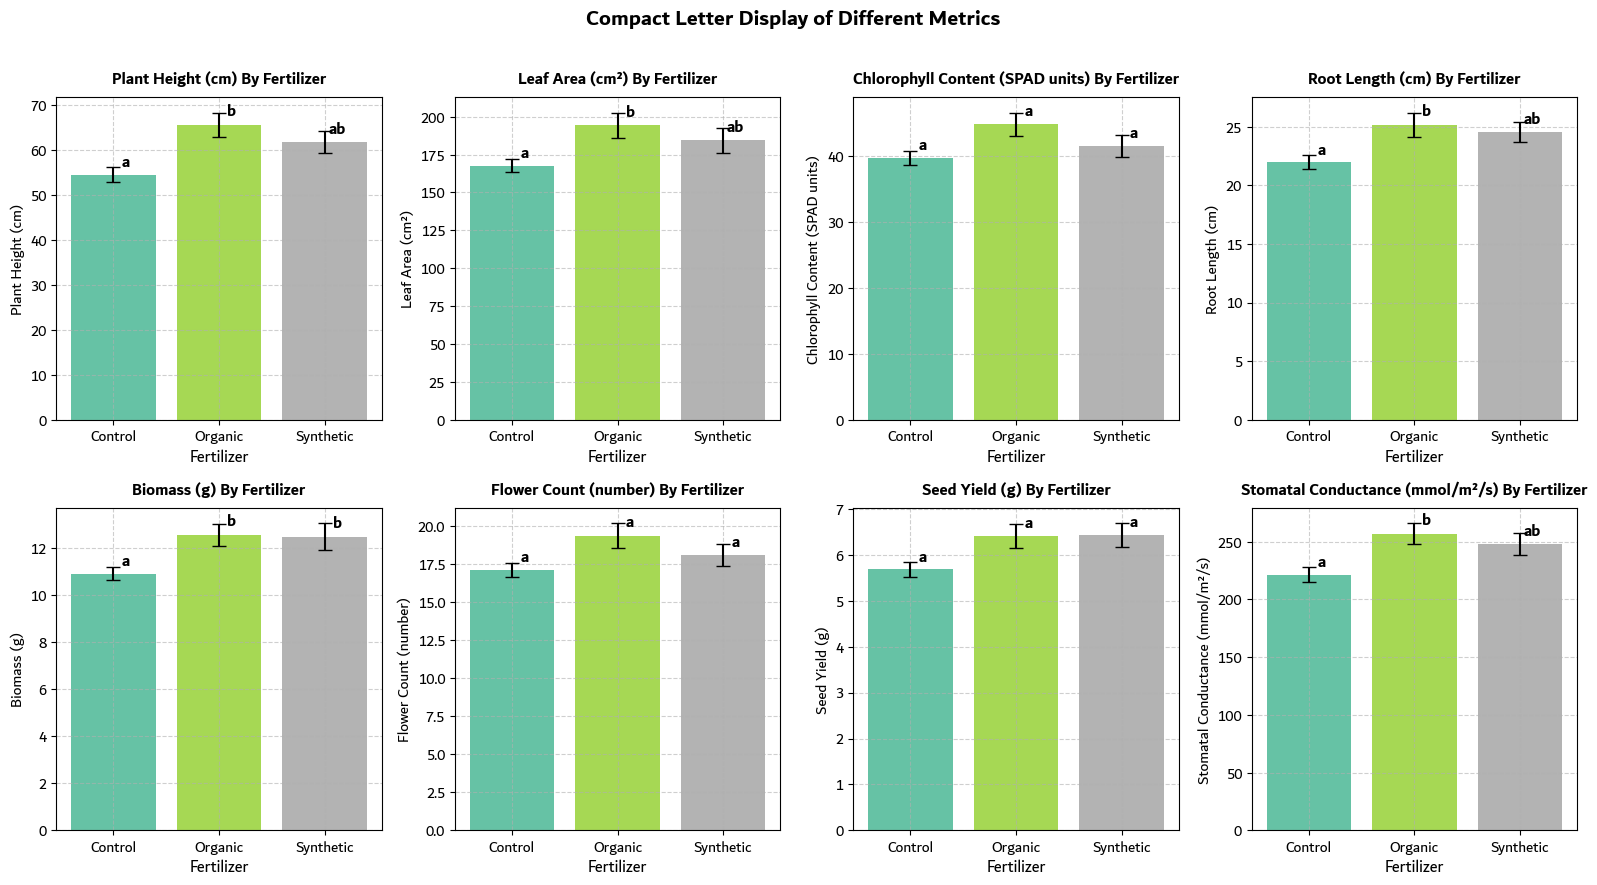

In [36]:
def compact_letter_visualizations(df, Metrics, group, savepath=None):
    df[Metrics].columns = df[Metrics].columns.to_series().apply(rename)
    num_variables = len(Metrics)
    cols = min(num_variables, 4)
    rows = math.ceil(num_variables / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5*rows))
    plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 11 })
    fig.suptitle("Compact Letter Display of Different Metrics", fontsize=16, fontweight="bold")
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, col in enumerate(Metrics):
        Turkey = pairwise_tukeyhsd(df[col], groups=df[group])
        Turkeyresults = pd.DataFrame(data=Turkey._results_table.data[1:], columns=Turkey._results_table.data[0])
        group_labels = letters(Turkeyresults)
        Aggregate_df = df.groupby(group)[col].agg(["mean", "sem"]).reset_index()
        ax = axes[idx]

        error = np.full(len(Aggregate_df), Aggregate_df["sem"])
        colors = plt.cm.Set2(np.linspace(0, 1, len(Aggregate_df)))
        bars = ax.bar(Aggregate_df[group], Aggregate_df["mean"], yerr=error, color=colors, capsize=5)
        for bar, Letters in zip(bars, Aggregate_df[group]):
            height = bar.get_height()
            offset = height * 0.02
            ax.annotate(group_labels[Letters],
                        xy=(bar.get_x() + bar.get_width() / 2, height + offset),
                        xytext=(9, 0),
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=12, fontweight="bold")
    
        
        ax.set_xticks(range(len(Aggregate_df[group])))
        ax.set_xticklabels(Aggregate_df[group], rotation=0, ha="center")
        ax.set_xlabel(group, fontsize=12)
        ax.set_ylabel(col, fontsize=11)
        ax.set_title(f"{col} By {group.title()}", fontsize=12, fontweight="bold", pad=10)
        ax.grid(linestyle="--", alpha=0.6)
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if savepath: plt.savefig(savepath)
    plt.show()

Metrics = df.select_dtypes(include=[np.number]).columns
compact_letter_visualizations(df, Metrics, group='Fertilizer', savepath=None)

---

This analysis was performed by Jabulente, a passionate and dedicated data analyst with a strong commitment to using data to drive meaningful insights and solutions.

----

<h1 style='font-size: 35px; color: Tomato; font-family: Colonna MT; font-weight: 700; text-align: center'>THE END</h1>